# Import packages

In [2]:
#import matplotlib.pyplot as plt
#import numpy as np
#import sys
#import time
#import ROOT
#import pandas as pd
#from root_pandas import read_root
#from matplotlib.ticker import NullFormatter
#import matplotlib as mpl
#from iminuit import Minuit, describe, Struct
#import astroML.plotting as aml


from array import array
import itertools
import time

import matplotlib.pyplot as plt
import numpy as np

import astroML.plotting as aml
import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from matplotlib.ticker import NullFormatter


Welcome to JupyROOT 6.09/01


# Defines how to get dataframe from ROOT TTree

In [3]:
def getData(inputFiles):
    
    cols = []
    cols.append('cluster_pt')
    cols.append('cluster_eta')
    cols.append('cluster_phi')
    cols.append('cluster_e_cross')
    cols.append('cluster_e')
    cols.append('cluster_ncell')
    cols.append('cluster_NN1')
    cols.append('cluster_NN2')
    cols.append('cluster_Lambda')
    
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print 'Processed', inputFilename, 'in',  end-start, 'seconds'
    return pd.concat([x for x in dataframes])

# Gets dataframes from dataset(s)

In [4]:
# NTuples found in /project/projectdirs/alice/NTuples
mcFiles = ["16c3b_small.root"]#["16c3b_small.root"]
dataFiles = ["13d_small.root"]#,"13e_small.root",'13e_small.root']
mcHists = getData(mcFiles)
dataHists = getData(dataFiles)

Processed 16c3b_small.root in 10.9435689449 seconds
Processed 13d_small.root in 18.0897231102 seconds


# Define cuts

In [5]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*cutDataframe.shape[0]/float(nbeforecut))
    return cutDataframe

In [6]:
def applyCuts(fullDataframe):  
    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e', inplace=True)
    
    dataframe = fullDataframe
    dataframe = applyCut(dataframe, 'cluster_pt>8.0', 'pt > 8 GeV:')
    dataframe = applyCut(dataframe, 'cluster_ecross_over_e>0.05', 'ecross/e > 0.05:')
    dataframe = applyCut(dataframe, 'cluster_NN1>0 and cluster_NN1<1.0')
    dataframe = applyCut(dataframe, 'cluster_NN2>0 and cluster_NN2<1.0', 'NN1 and NN2 between 0 and 1:')
    dataframe = applyCut(dataframe, 'cluster_ncell>2', 'ncell > 2:')
    dataframe = applyCut(dataframe, 'cluster_Lambda<2.0', 'lambda < 2.0:')
    return dataframe

# Apply cuts

In [7]:
dataHists = applyCuts(dataHists)
mcHists = applyCuts(mcHists)

pt > 8 GeV: 326202  fraction kept: 3.6
ecross/e > 0.05: 255603  fraction kept: 78.4
NN1 and NN2 between 0 and 1: 243129  fraction kept: 99.7
ncell > 2: 242976  fraction kept: 99.9
lambda < 2.0: 242613  fraction kept: 99.9
pt > 8 GeV: 275653  fraction kept: 9.1
ecross/e > 0.05: 269121  fraction kept: 97.6
NN1 and NN2 between 0 and 1: 268465  fraction kept: 100.0
ncell > 2: 268163  fraction kept: 99.9
lambda < 2.0: 268028  fraction kept: 99.9


# Define plotting 

In [57]:
def plotcorr(histo,label,figname,nbins=1000):
    y = histo['cluster_NN1']
    x = histo['cluster_Lambda']
    nullfmt = NullFormatter()         # no labels
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.04
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    fig = plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    axHistx.xaxis.set_major_formatter(nullfmt) #no labels
    axHisty.yaxis.set_major_formatter(nullfmt)
    hb = axScatter.hexbin(x, y, cmap='viridis', gridsize=300)#, gridsize=500) #gridsize=60
    #axScatter.plot((0, 1), (0.27, 0.27), 'r-',linestyle=':')
    
    #axScatter.plot((0.245, 0.245), (0, 1.0), 'r-',linestyle=':')
    #axScatter.plot((0.255, 0.255), (0, 1.0), 'r-',linestyle=':')
    plt.text(0.22, 0.90,label, horizontalalignment='center',  verticalalignment='center', transform=axScatter.transAxes, bbox=dict(facecolor='white', alpha=0.75))
    binwidth = 0.25
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    axScatter.set_xlim((0.0, 1.0))
    axScatter.set_ylim((0.0, 1.0))
    axScatter.set_ylabel('NN output')
    axScatter.set_xlabel('Lambda')
    yhist, xhist, patches = axHistx.hist(x,nbins, range=(0, 1.0)) #here it gets the NN histogram
    xhist= np.delete(xhist,-1)
    xhist = np.add( xhist, (xhist[1]-xhist[0])/2.0 )
    yerrhist = np.sqrt(yhist)
    xerrhist = np.full(len(yerrhist), (xhist[1]-xhist[0])/2.0)
    axHisty.hist(y,nbins, range=(0.0,1.0), orientation='horizontal')
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    plt.show()
    #plt.clf()
    #plt.close()
    #plt.hist(y,nbins, range=(0.0,1.0))
    fig.savefig('../JupyterPNGOutput/'+figname+'.png', dpi=fig.dpi)
    return yhist, xhist, yerrhist, xerrhist
    

# Function to cut pt ranges

In [8]:
def cutptrange(data, ptmin, ptmax):
    datacut = data.query('cluster_pt>%f and cluster_pt<%f' %(ptmin,ptmax))
    print 'number of clusters after cut', datacut.shape[0]
    return datacut

# Define pt bins and plot

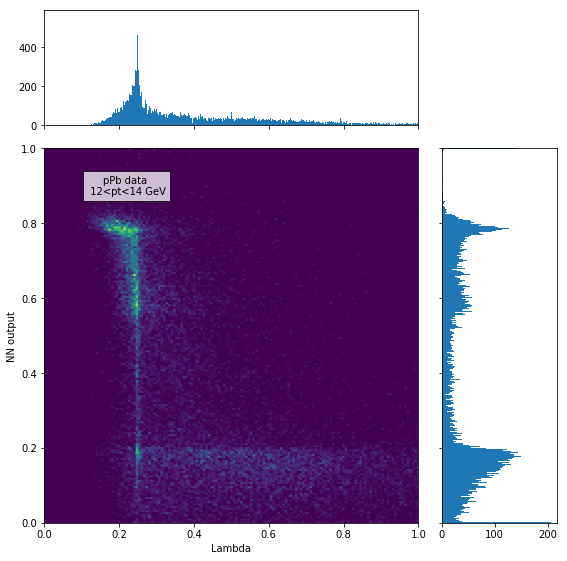

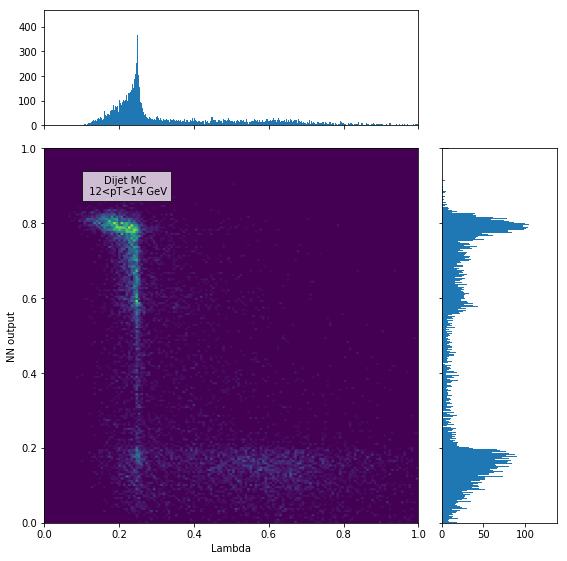

number of clusters after cut 36343
number of clusters after cut 23483


In [58]:
binedges = [12.0, 14.0]

for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    datacut= cutptrange(dataHists, ptmin, ptmax)
    plotcorr(datacut,'pPb data \n %2.0f<pt<%2.0f GeV' %(ptmin,ptmax),'all_Data%2.0f_%2.0f' %(ptmin,ptmax))
    ##dealing with MC
    mcdatacut = cutptrange(mcHists, ptmin, ptmax)
    plotcorr(mcdatacut,'Dijet MC \n %2.0f<pT<%2.0f GeV' %(ptmin,ptmax),'all_MC_%2.0f_%2.0f' %(ptmin,ptmax))
    
    
    

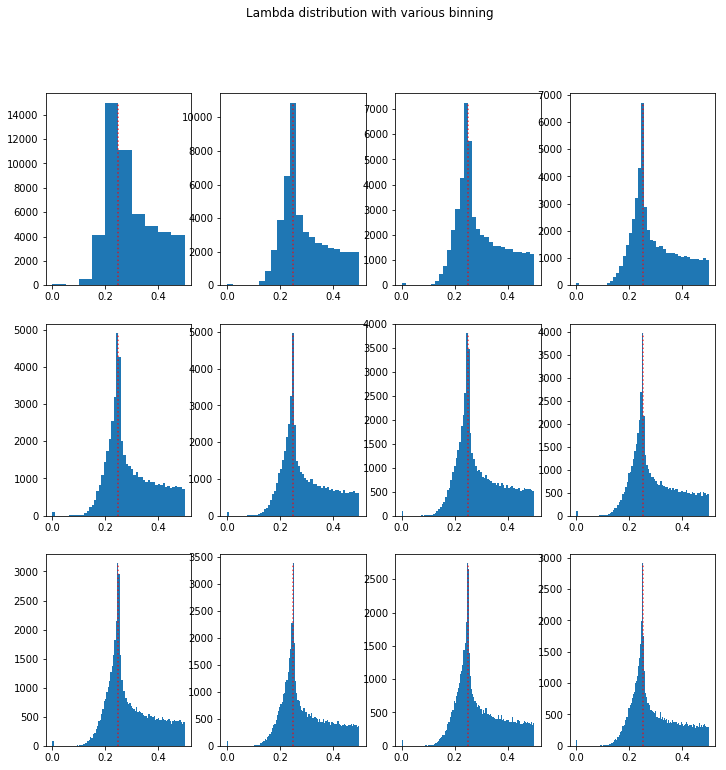

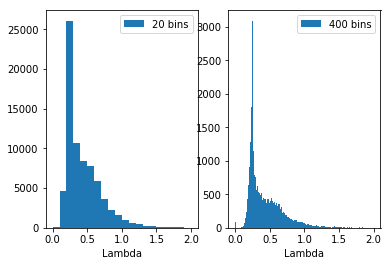

number of clusters after cut 74086


In [60]:
binedges = [12.0, 20.0]

for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    datacut= cutptrange(dataHists, ptmin, ptmax)
    fig = plt.figure(1, figsize=(24, 8))
    
    fig = plt.figure(figsize=(12,12))
    for i in range(12):
        plt.subplot(3,4,i+1)
        nbins =int(i)*11+10
        a,x,y = plt.hist(datacut["cluster_Lambda"], bins=nbins, range=(0.0,0.50),label='%i bins' %nbins )
        plt.plot((0.250, 0.250), (0, np.amax(a)), 'r-',linestyle=':',alpha=0.75)
        #plt.legend()
        #axScatter.plot((0.85, 0.85), (0, 1.0), 'r-',linestyle=':')
 
    plt.suptitle('Lambda distribution with various binning')
    plt.show()
    fig.savefig('../JupyterPNGOutput/variousbinning.png', dpi=fig.dpi)
    
    
    fig = plt.figure()#figsize=(12,12))
    plt.subplot(1,2,1)
    
    plt.hist(datacut["cluster_Lambda"], bins=20, range=(0.0,2.0),label='20 bins')
    plt.xlabel('Lambda')
    plt.legend()
    plt.subplot(1,2,2)
    plt.hist(datacut["cluster_Lambda"], bins=400, range=(0.0,2.0),label='400 bins')
    plt.xlabel('Lambda')
    plt.legend()
    plt.show()
    fig.savefig('../JupyterPNGOutput/Lambda.png', dpi=fig.dpi)
    #aml.hist(datacut["cluster_Lambda"], bins='blocks', normed=True, range=(0.15,0.50))
    #plt.subplot(1,2,2)
    #aml.hist(datacut["cluster_Lambda"], bins='blocks', normed=False, range=(0.1,0.50))
    #plt.show()
     
    

  